<a href="https://colab.research.google.com/github/aselshall/AR_HAB/blob/main/AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
import numpy as np
import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Check stationarity  
from statsmodels.tsa.stattools import grangercausalitytests  #Check time series Grange causality

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg,ar_select_order
from statsmodels.tsa.vector_ar.var_model import VAR


import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

#### [1] Load and prepare data

In [ ]:
#Read data
df=pd.read_csv('data.csv')
display(df.tail(5))

#Convert text to date
df['Week'] = pd.to_datetime(df['Week'])

#Rename columns
df.rename(columns={'Week': 'date', 'Weekly breakdown ':'week', 'Avg Weekly Flu': 'Flu', 'Avg Weekly Pollen': 'Pollen', 'Avg Weekly Temperature ': 'Temp', \
'Avg Weekly K.Brevis': 'KB', 'Tourists (%occupancy)': 'Tourist', 'ED Visits (all)': 'EDtot', 'ED Vistis (bronchitis/UAD)': 'EDbu'},inplace=True)

#Create Temp(t-1)
df.insert(5, 'Temp_L1', df['Temp'].shift(1))

#Transform KB and create KB(t-1)
#HAB measure is the square root of one-thousandth of the weekly average of daily average K. brevis cell counts.
#In the model, we tested for a 1-week lag for the in situ HAB cell count
df.insert(7, 'HAB_L1', (df['KB']/1000).pow(1/2).shift(1))

#Fill dummy tourist data
df.loc[0:37,'Tourist']=df.loc[52:52+37,'Tourist'].to_numpy()

#Convert tourist percent to float 
df["Tourist"] = [float(str(i).replace("%", "")) for i in df["Tourist"]]

#Natural log transform of EDtot and EDbu
df.insert(11, 'lnEDtot', np.log(df['EDtot']))
df.insert(12, 'lnEDbu', np.log(df['EDbu']))

#Delete irrelevant columns 
df.drop(columns=['week','KB'],inplace=True)

#Delete rows as needed
df.drop([0],inplace=True)

#set date as index
df.set_index('date',inplace=True)

#Rearrange columns
df = df[['HAB_L1','Temp','Temp_L1','Flu','Pollen','Tourist','EDtot','EDbu','lnEDtot','lnEDbu']]

#Display data
display(df.tail(5))

,Week,Weekly breakdown,Avg Weekly Flu,Avg Weekly Pollen,Avg Weekly Temperature,Avg Weekly K.Brevis,Tourists (%occupancy),ED Visits (all),ED Vistis (bronchitis/UAD)
124,8.26.2006,257,0.0,29,82,3366496,50%,110,80
125,9.2.2006,258,0.0,34,81,3988648,48%,164,114
126,9.9.2006,259,0.0,41,81,593743,48%,164,114
127,9.16.2006,260,0.0,54,81,494441,48%,164,114
128,9.23.2006,261,0.0,50,80,565516,48%,164,114


,HAB_L1,Temp,Temp_L1,Flu,Pollen,Tourist,EDtot,EDbu,lnEDtot,lnEDbu
date,,,,,,,,,,
2006-08-26,52.911927,82,81.0,0.0,29,50.0,110,80,4.700480,4.382027
2006-09-02,58.021513,81,82.0,0.0,34,48.0,164,114,5.099866,4.736198
2006-09-09,63.155744,81,81.0,0.0,41,48.0,164,114,5.099866,4.736198
2006-09-16,24.366842,81,81.0,0.0,54,48.0,164,114,5.099866,4.736198
2006-09-23,22.236029,80,81.0,0.0,50,48.0,164,114,5.099866,4.736198


#### [2] Visualize data

In [ ]:
def Visualize(data,plt,Title):
    Ncols=4
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)-2
    fig, axes = plt.subplots(nrows=int(np.ceil(feature_size/Ncols)), ncols=Ncols, figsize=(14, 7), dpi=80, facecolor="w", edgecolor="k")
    
    for i in range(feature_size):
        key = features[i]
        c = 'blue'
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(ax=axes[i // Ncols, i % Ncols], marker='.', linestyle='-',color='blue', mfc='orange', mec='orange', title="{}".format(Title[i]),rot=0)
        ax.legend([key])
    plt.tight_layout()

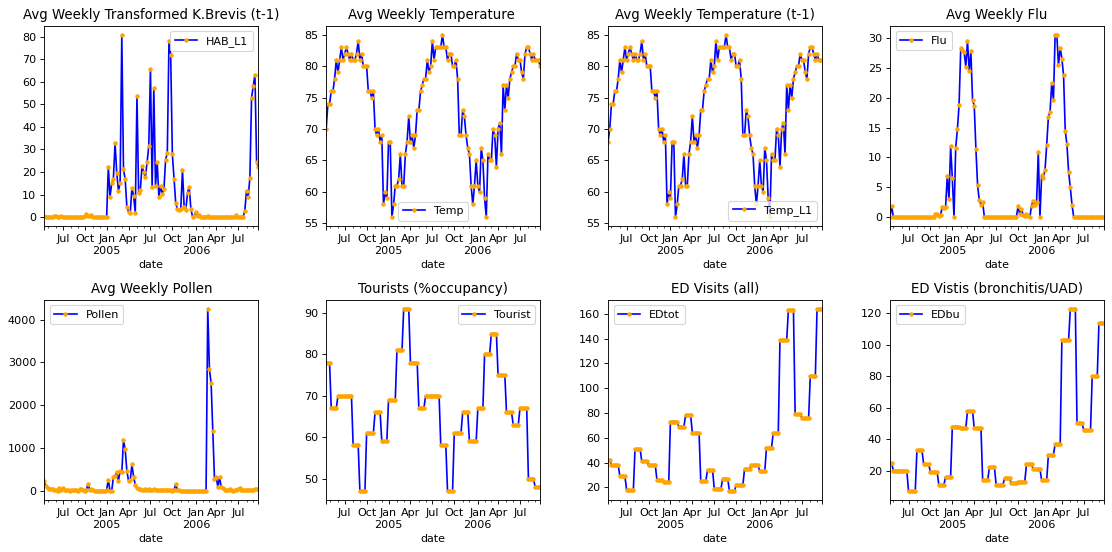

In [ ]:
#Visualize data
Title=['Avg Weekly Transformed K.Brevis (t-1)', 'Avg Weekly Temperature ', 'Avg Weekly Temperature (t-1)', 'Avg Weekly Flu', \
       'Avg Weekly Pollen', 'Tourists (%occupancy)', 'ED Visits (all)', 'ED Vistis (bronchitis/UAD)']
Visualize(df,plt,Title)

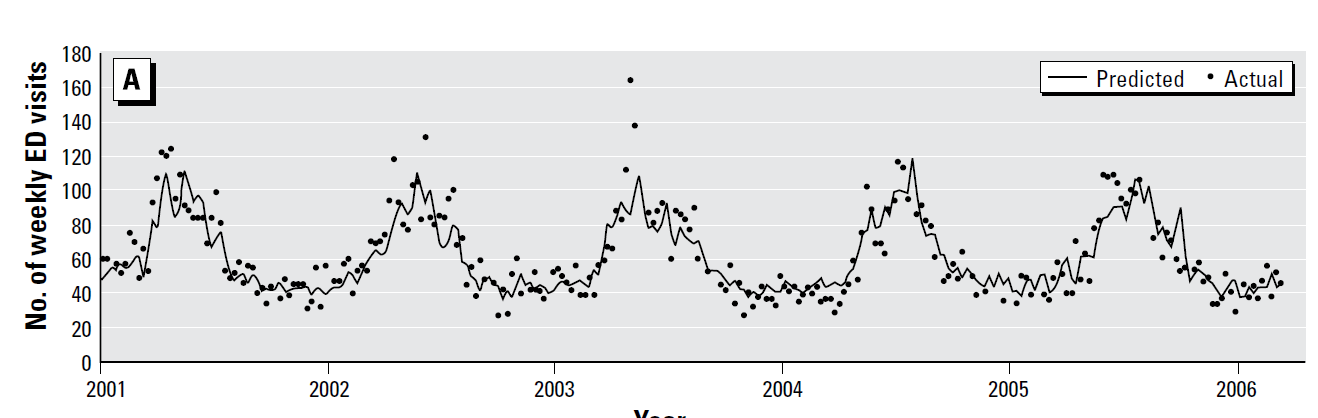

Weekly ED visits for UAD and bronchitis. (A) Number of actual SMH ED visits in each week for UAD and bronchitis and the predicted number of visits for the same illnesses using model II.

#### [3] summary statistics
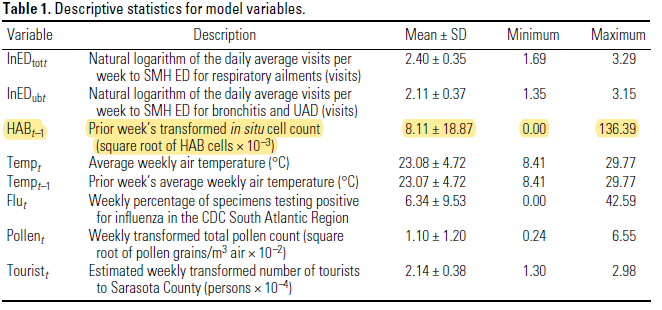

The total number of daily SMH ED visits for respiratory diagnoses were compiled from October 2001 through September 2006. <br>
The text did not mention any transformation of the data as shown in Table1. 

In [ ]:
print('Hoagland et al 2009 lnED(tot) weekly average',str.format('{0:.2f}', math.exp(2.4)*7))
print('Hoagland et al 2009 lnED(bu)  weekly average',str.format('{0:.2f}', math.exp(2.11)*7))
df.describe()

Hoagland et al 2009 lnED(tot) weekly average 77.16
Hoagland et al 2009 lnED(bu)  weekly average 57.74


,HAB_L1,Temp,Temp_L1,Flu,Pollen,Tourist,EDtot,EDbu,lnEDtot,lnEDbu
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,10.171968,73.968750,73.875000,5.293750,171.203125,66.468750,56.195312,36.726562,3.817180,3.314163
std,17.446400,8.034314,8.033395,9.097025,527.765657,10.482034,39.998634,30.612312,0.637073,0.748052
min,0.000000,56.000000,56.000000,0.000000,0.000000,47.000000,17.000000,7.000000,2.833213,1.945910
25%,0.000000,68.000000,68.000000,0.000000,14.000000,59.000000,27.000000,15.000000,3.295837,2.708050
50%,0.686911,76.000000,76.000000,0.000000,28.000000,67.000000,38.000000,24.000000,3.637586,3.178054
75%,13.837846,81.000000,81.000000,6.675000,63.000000,70.000000,73.000000,47.000000,4.290459,3.850148
max,80.818408,85.000000,85.000000,30.600000,4252.000000,91.000000,164.000000,123.000000,5.099866,4.812184


Our ED data mean value does not match that of Hoagland et al (2009)

#### [4] Check if data is stationary using the Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation. Unit root recognizes the possibility that a shock may give rise to transitory dynamics, and may come back towards, but not all the way towards your previous estimate. Unit root is the same as a combination of a stationary component and a bit of a random walk.<br>
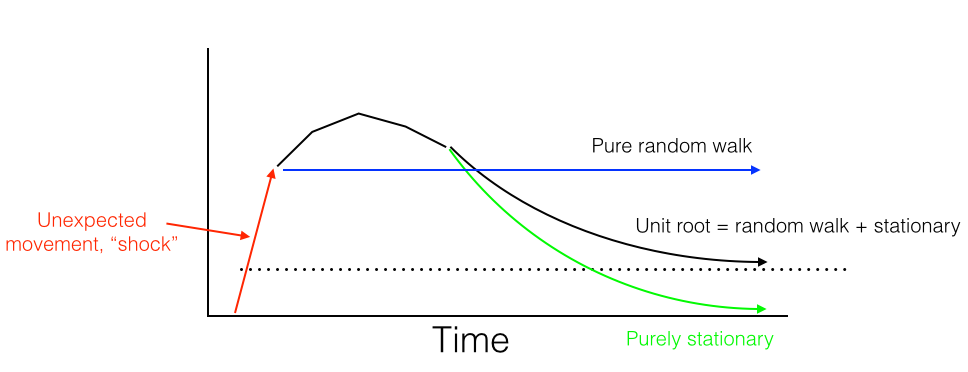

[Source: Cochrane 2021)](https://johnhcochrane.blogspot.com/2015/04/unit-roots-in-english-and-pictures.html)

*Null hypothesis: Non Stationarity exists in the series (i.e., series possesses a unit root)<br>
*Alternative Hypothesis: Stationarity exists in the series.<br>

In [ ]:
for i in range(len(df.columns)):
    result = adfuller(df[df.columns[i]])
    if result[1] > 0.05 :
        print('{}: non stationary (p_value {})'.format(df.columns[i], str.format('{0:.6f}',result[1])))
    else:
        print('{}: stationary (p_value {})'.format(df.columns[i], str.format('{0:.6f}',result[1])))

HAB_L1: stationary (p_value 0.001996)
Temp: stationary (p_value 0.000004)
Temp_L1: stationary (p_value 0.000004)
Flu: stationary (p_value 0.007696)
Pollen: stationary (p_value 0.000013)
Tourist: non stationary (p_value 0.175500)
EDtot: non stationary (p_value 0.942280)
EDbu: non stationary (p_value 0.890921)
lnEDtot: non stationary (p_value 0.520050)
lnEDbu: non stationary (p_value 0.343948)


*Tourists series non stationary might be due to repeating  monthly data weekly. <br>
*ED series non stationary might be due (1) possible data error, (2) repeating the monthly data weekly

#### [5] Granger causality
The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.<br>
*Null hypothesis (H0): Xt does not granger causes Yt (p_value > 0.05) <br>
*Alternative Hypothesis (H1): Xt granger causes Yt (p_value <= 0.05) <br>

In [ ]:
max_lags=10
y='EDbu'
p_test=ptest=['empty']*max_lags
for column in range(len(df.columns)):
    results=grangercausalitytests(df[[y,df.columns[column]]], max_lags, verbose=False)
    p_values=[round(results[column+1][0]['ssr_ftest'][1],4) for column in range(max_lags)]
    for p_count,p_value in enumerate(p_values):
        if p_value> 0.05:
            p_test[p_count]='H0({})'.format(p_values[p_count])
        else:
            p_test[p_count]='H1({})'.format(p_values[p_count])
    print('{} : {}'.format(df.columns[column],p_test))
    
# Flu [1,5,6,7,8,9]    
# Pollen [5...10]

HAB_L1 : ['H0(0.5925)', 'H0(0.6773)', 'H0(0.7894)', 'H0(0.8888)', 'H0(0.9453)', 'H0(0.9843)', 'H0(0.9901)', 'H0(0.9516)', 'H0(0.7194)', 'H0(0.7391)']
Temp : ['H0(0.2112)', 'H0(0.1813)', 'H0(0.3591)', 'H0(0.5412)', 'H0(0.6187)', 'H0(0.4842)', 'H0(0.5995)', 'H0(0.6428)', 'H0(0.6461)', 'H0(0.1226)']
Temp_L1 : ['H0(0.5496)', 'H0(0.7379)', 'H0(0.8925)', 'H0(0.9313)', 'H0(0.6758)', 'H0(0.8548)', 'H0(0.8974)', 'H0(0.669)', 'H0(0.3875)', 'H0(0.3051)']
Flu : ['H1(0.0194)', 'H0(0.0621)', 'H0(0.0594)', 'H0(0.1228)', 'H1(0.0157)', 'H1(0.0303)', 'H1(0.0358)', 'H1(0.0426)', 'H0(0.0526)', 'H1(0.0232)']
Pollen : ['H0(0.6244)', 'H0(0.628)', 'H0(0.2208)', 'H0(0.1086)', 'H1(0.0015)', 'H1(0.0)', 'H1(0.0001)', 'H1(0.0)', 'H1(0.0001)', 'H1(0.0)']
Tourist : ['H0(0.6725)', 'H0(0.8895)', 'H0(0.9473)', 'H0(0.9745)', 'H0(0.9797)', 'H0(0.9835)', 'H0(0.9932)', 'H0(0.9973)', 'H0(0.7043)', 'H0(0.4991)']
EDtot : ['H1(0.0414)', 'H0(0.0996)', 'H0(0.154)', 'H0(0.1942)', 'H0(0.142)', 'H0(0.1465)', 'H0(0.1401)', 'H0(0.110

*Flu and Pollen granger cause ER visits. <br>
*A big factor that this missing is ED visits due to chronic respiratory diseases

#### [6] Models for multivariate regression
"Exposure–response model: Table 2 presents Yule-Walker estimates of two different autoregressive error models corrected for third-order autocorrelation"(Hogland et al. 2009). <br>
Each model considers a different dependent variable:<br>
*In model I, the dependent variable is the natural logarithm of SMH ED visits for all respiratory ailments (lnEDtot).<br> 
*In model II, the dependent variable is the natural logarithm of SMH ED visits for the combination of UAD/bronchitis (lnEDub).<br>
I guess third order autocorrelation and accounting for multiple variables indicate that we need to use VAR(3). <br>
Yet according to granger causality we should only account for Flu and Pollen and used VAR(10).<br>
<br>
[1] VAR(p) where all variables are endogness variables:<br>
[statsmodels.tsa.vector_ar.var_model.VAR](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html)<br>
class statsmodels.tsa.vector_ar.var_model.VAR(endog, exog=None, dates=None, freq=None, missing='none') <br>
$ lnED_t=\beta_0 +\
\sum\limits _{i=1} ^{p} \beta_{1,i}(lnED_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{2,i}(HAB_{t-1})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{3,i}(Temp_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{4,i}(Temp_{t-1})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{5,i}(Flu_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{6,i}(Pollen_{t})_{t-i} +
\sum\limits _{i=1} ^{p} \beta_{7,i}(Tourist_{t})_{t-i} + \epsilon_t $ <br>
<br>

[2] AR(p) where all variables other than lnED are exogness variables: <br>
[statsmodels.tsa.ar_model.AutoReg](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg)<br>
class statsmodels.tsa.ar_model.AutoReg(endog, lags, trend='c', seasonal=False, exog=None, hold_back=None, period=None, missing='none', *, deterministic=None, old_names=None)
$ lnED_t=\beta_0 +\
\sum\limits _{i=1} ^{p} \beta_{1,i}(lnED_{t-i}) +\
\beta_{2}(HAB_{t-1}) +\
\beta_{3}(Temp_{t}) +\
\beta_{4}(Temp_{t-1}) +\
\beta_{5}(Flu_{t}) +\
\beta_{6}(Pollen_{t}) +
\beta_{7}(Tourist_{t}) + \epsilon_t $<br>

[3] Linear Regression: <br>
[sm.OLS](https://www.statsmodels.org/stable/regression.html)<br>
$ lnED_t=\beta_0 +\
\beta_{1}(HAB_{t-1}) +\
\beta_{2}(Temp_{t}) +\
\beta_{3}(Temp_{t-1}) +\
\beta_{4}(Flu_{t}) +\
\beta_{5}(Pollen_{t}) +
\beta_{6}(Tourist_{t}) + \epsilon_t $<br>

It is unclear which one is used if any because Table 2 has only on parameter for each variable! <br>
<br>
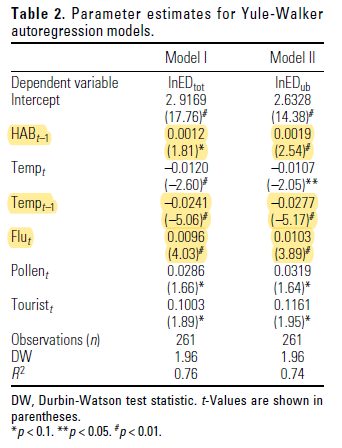

#### Plot time series

In [ ]:
def tsplot(data,predictions):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
    ax = np.exp(data).plot(marker='.', linestyle='',mfc='orange', mec='orange',figsize=(15,5),legend='data')
    ax=np.exp(predictions).plot(linestyle='-',color='blue',legend='model')
    ax.legend(['data', 'model']);
    ax.set_xlabel("date")
    ax.set_ylabel('EDbu')
    plt.tight_layout()

#### Prepare data

In [ ]:
endog=df['lnEDbu']
exog=df[['HAB_L1','Temp','Temp_L1','Flu','Pollen','Tourist']]

#### [2] AR(p) where all variables other than lnED are exogness variables
[statsmodels.tsa.ar_model.AutoReg](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg)<br>
class statsmodels.tsa.ar_model.AutoReg(endog, lags, trend='c', seasonal=False, exog=None, hold_back=None, period=None, missing='none', *, deterministic=None, old_names=None)
$ lnED_t=\beta_0 +\
\sum\limits _{i=1} ^{p} \beta_{1,i}(lnED_{t-i}) +\
\beta_{2}(HAB_{t-1}) +\
\beta_{3}(Temp_{t}) +\
\beta_{4}(Temp_{t-1}) +\
\beta_{5}(Flu_{t}) +\
\beta_{6}(Pollen_{t}) +
\beta_{7}(Tourist_{t}) + \epsilon_t $<br>

(2.1) Manual lag selection<br>
The trend to include in the model:<br>
'n' - No trend.<br>
'c' - Constant only.<br>
't' - Time trend only.<br>
'ct' - Constant and time trend<br>

In [ ]:
#Select lag
for lag in range(15):
    model=AutoReg(endog,exog=exog, trend='c', lags = lag+1)
    results=model.fit()
    print('Order = ', lag+1,'BIC: ', results.bic)

Order =  1 BIC:  -2.214272503609834
Order =  2 BIC:  -2.167205636808442
Order =  3 BIC:  -2.120501961703848
Order =  4 BIC:  -2.070997100226228
Order =  5 BIC:  -2.033416185032176
Order =  6 BIC:  -2.0070924079645724
Order =  7 BIC:  -1.956010778925755
Order =  8 BIC:  -1.9073752453251869
Order =  9 BIC:  -1.8549377622383811
Order =  10 BIC:  -1.8207805729833755
Order =  11 BIC:  -1.768934903644083
Order =  12 BIC:  -1.8421918521370846
Order =  13 BIC:  -1.7887167857118098
Order =  14 BIC:  -1.7447391748519538
Order =  15 BIC:  -1.698154755370687


                            AutoReg Model Results                             
Dep. Variable:                 lnEDbu   No. Observations:                  128
Model:                   AutoReg-X(1)   Log Likelihood                 -17.800
Method:               Conditional MLE   S.D. of innovations              0.278
Date:                Thu, 22 Apr 2021   AIC                             -2.416
Time:                        12:01:22   BIC                             -2.214
Sample:                    04-24-2004   HQIC                            -2.334
                         - 09-23-2006                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6699      0.418      1.601      0.109      -0.150       1.490
lnEDbu.L1      0.8983      0.036     25.086      0.000       0.828       0.968
HAB_L1        -0.0026      0.001     -1.729      0.0

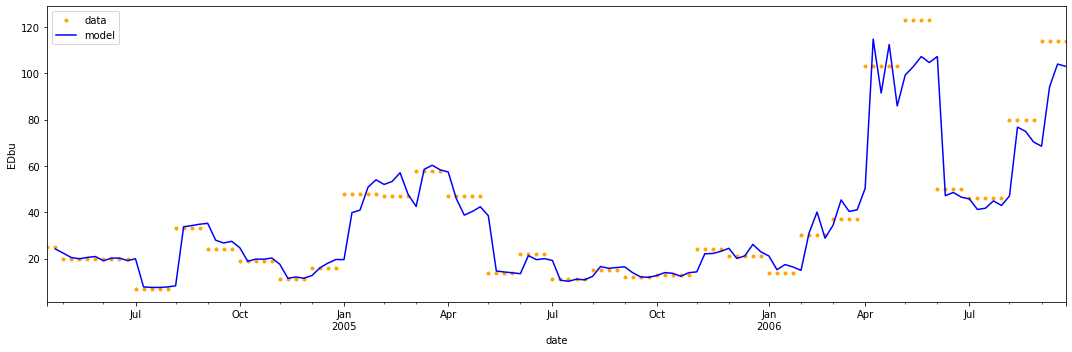

In [ ]:
#Create ad 
model=AutoReg(endog, exog=exog,trend='c',lags = 1)
results=model.fit()
print(results.summary())
tsplot(endog,results.fittedvalues)

(2.2) Automatic lag selection

                            AutoReg Model Results                             
Dep. Variable:                 lnEDbu   No. Observations:                  128
Model:                   AutoReg-X(1)   Log Likelihood                 -17.800
Method:               Conditional MLE   S.D. of innovations              0.278
Date:                Thu, 22 Apr 2021   AIC                             -2.416
Time:                        12:03:20   BIC                             -2.214
Sample:                    04-24-2004   HQIC                            -2.334
                         - 09-23-2006                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6699      0.418      1.601      0.109      -0.150       1.490
lnEDbu.L1      0.8983      0.036     25.086      0.000       0.828       0.968
HAB_L1        -0.0026      0.001     -1.729      0.0

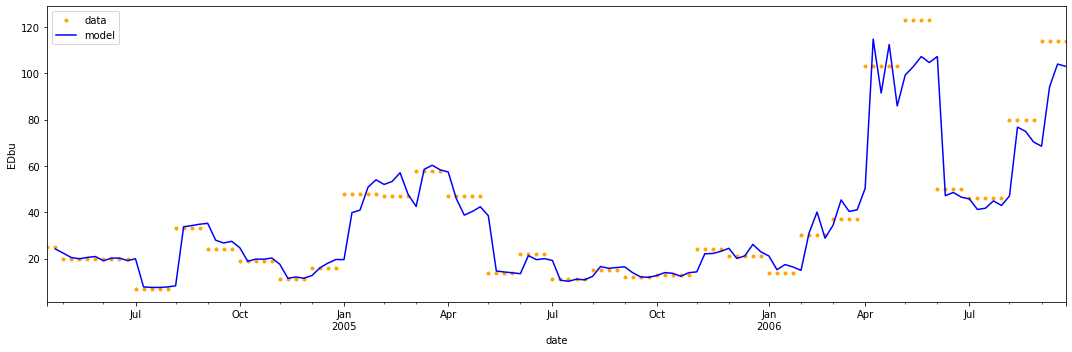

In [ ]:
#Maximum lag selection
lags = ar_select_order(endog, exog=exog, trend='c',maxlag=10)


model = AutoReg(endog, exog=exog,  trend='c', lags=lags.ar_lags)
results=model.fit()
print(results.summary())
tsplot(endog,results.fittedvalues)

(2.3) Model prediction

In [ ]:
#Display parameters
print('fitted parameters:')
display(results.params)

#Display data 
print('data:')
display(np.exp(endog).head(5))

#Model prediction
print('model prediction:')
display(np.exp(results.fittedvalues).round().head(4))

#Automatic prediction
print('automatic prediction:')
predict=results.predict(start=0, end=len(endog)-1)
display(np.exp(predict).round().head(5))


#Manual prediction
print('manual prediction:')
params=results.params
for lag in range(len(endog)-1):
    predict.iloc[lag+1]=params[0]+np.sum(params[2:]*exog.iloc[lag+1])+params[1]*endog.iloc[lag]
predwHAB=np.exp(predict).round()
display(predwHAB.head(5))

#Manual prediction without HAB
print('manual prediction without HAB:')
params=results.params.copy()
params[2]=0
for lag in range(len(endog)-1):
    predict.iloc[lag+1]=results.params[0]+np.sum(results.params[2:]*exog.iloc[lag+1])+results.params[1]*endog.iloc[lag]
predwoHab=np.exp(predict).round()    
display(predwoHab.head(5))

#Hab contribution
Hab=predwHAB-predwoHab
print('EDbu due to HAB',np.sum(Hab))

fitted parameters:


intercept    0.669862
lnEDbu.L1    0.898253
HAB_L1      -0.002565
Temp         0.014950
Temp_L1     -0.013187
Flu          0.014073
Pollen      -0.000033
Tourist     -0.007479
dtype: float64

data:


date
2004-04-17    25.0
2004-04-24    25.0
2004-05-01    20.0
2004-05-08    20.0
2004-05-15    20.0
Name: lnEDbu, dtype: float64

model prediction:


date
2004-04-24    24.0
2004-05-01    22.0
2004-05-08    20.0
2004-05-15    20.0
dtype: float64

automatic prediction:


2004-04-17     NaN
2004-04-24    24.0
2004-05-01    22.0
2004-05-08    20.0
2004-05-15    20.0
Freq: W-SAT, dtype: float64

manual prediction:


2004-04-17     NaN
2004-04-24    24.0
2004-05-01    22.0
2004-05-08    20.0
2004-05-15    20.0
Freq: W-SAT, dtype: float64

manual prediction without HAB:


2004-04-17     NaN
2004-04-24    24.0
2004-05-01    22.0
2004-05-08    20.0
2004-05-15    20.0
Freq: W-SAT, dtype: float64

EDbu due to HAB 0.0


#### [3] Linear Regression
[sm.OLS](https://www.statsmodels.org/stable/regression.html)<br>
$ lnED_t=\beta_0 +\
\beta_{1}(HAB_{t-1}) +\
\beta_{2}(Temp_{t}) +\
\beta_{3}(Temp_{t-1}) +\
\beta_{4}(Flu_{t}) +\
\beta_{5}(Pollen_{t}) +
\beta_{6}(Tourist_{t}) + \epsilon_t $<br>
GLS : generalized least squares for arbitrary covariance Σ <br>
OLS : ordinary least squares for i.i.d. errors Σ=I <br>
WLS : weighted least squares for heteroskedastic errors diag(Σ) <br>
GLSAR : feasible generalized least squares with autocorrelated AR(p) errors Σ=Σ(ρ) <br>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                GLSAR Regression Results                               
=======================================================================================
Dep. Variable:                 lnEDbu   R-squared (uncentered):                   0.957
Model:                          GLSAR   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              452.9
Date:                Wed, 21 Apr 2021   Prob (F-statistic):                    2.20e-80
Time:                        23:13:44   Log-Likelihood:                         -135.20
No. Observations:                 127   AIC:                                      282.4
Df Residuals:                     121   BIC:                                      299.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HAB_L1        -0.0024      0.004     -0.633      0.528      -0.010       0.005
Temp           0.0410      0.020      2.070      0.041       0.002       0.080
Temp_L1        0.0024      0.019      0.127      0.899      -0.036       0.041
Flu            0.0613      0.013      4.901      0.000       0.037       0.086
Pollen        -0.0002      0.000     -1.201      0.232      -0.000       0.000
Tourist       -0.0027      0.007     -0.375      0.708      -0.017       0.012
==============================================================================
Omnibus:                        2.860   Durbin-Watson:                   0.272
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.888
Skew:                           0.351   Prob(JB):                        0.236
Kurtosis:                       2.770   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

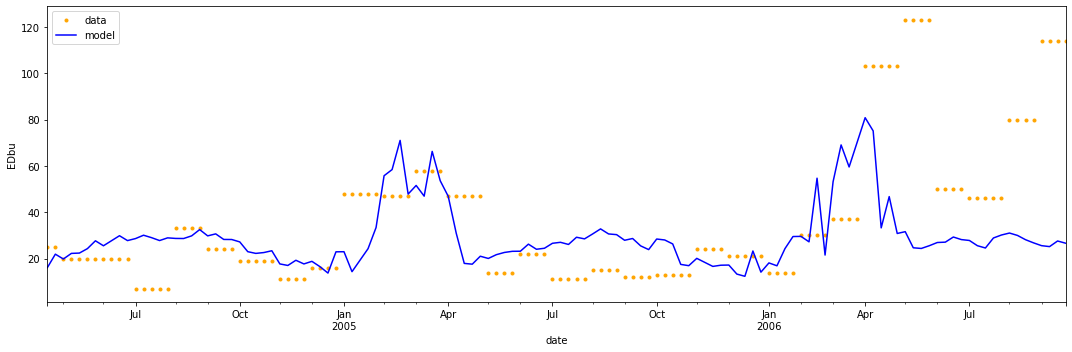

In [ ]:
# Fit and summarize OLS model
# OLS, WLS, GLS, GLSAR 
model= sm.GLSAR(endog, exog)
results= model.fit()
display(results.summary())
tsplot(endog,results.fittedvalues)

#### [1] VAR(p) where all variables are endogness variables:<br>
[statsmodels.tsa.vector_ar.var_model.VAR](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html)<br>
class statsmodels.tsa.vector_ar.var_model.VAR(endog, exog=None, dates=None, freq=None, missing='none') <br>
$ lnED_t=\beta_0 +\
\sum\limits _{i=1} ^{p} \beta_{1,i}(lnED_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{2,i}(HAB_{t-1})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{3,i}(Temp_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{4,i}(Temp_{t-1})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{5,i}(Flu_{t})_{t-i} +\
\sum\limits _{i=1} ^{p} \beta_{6,i}(Pollen_{t})_{t-i} +
\sum\limits _{i=1} ^{p} \beta_{7,i}(Tourist_{t})_{t-i} + \epsilon_t $ <br>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Apr, 2021
Time:                     09:48:30
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -36.7492
Nobs:                     127.000    HQIC:                  -37.4938
Log likelihood:           1207.78    FPE:                3.13222e-17
AIC:                     -38.0034    Det(Omega_mle):     2.04240e-17
--------------------------------------------------------------------
Results for equation lnEDbu
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.485897         0.441066            1.102           0.271
L1.lnEDbu          0.895338         0.038558           23.220           0.000
L1.HAB_L1         -0.000532         0.001552           -0.343          

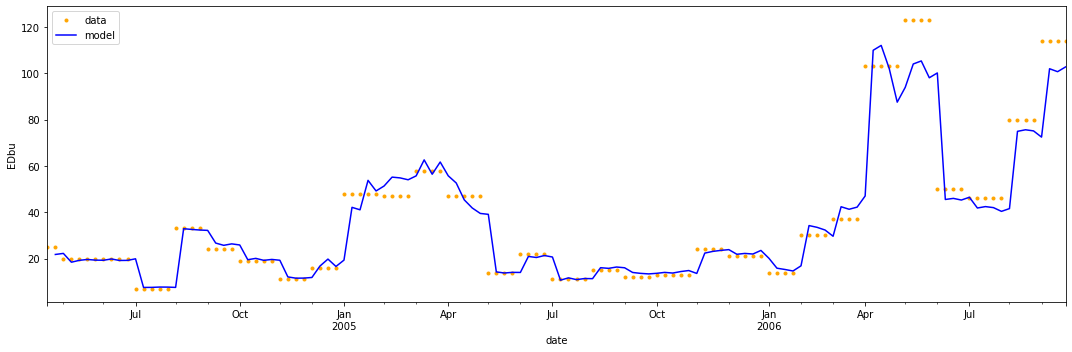

In [ ]:
#Prepare data
endog=df[['lnEDbu','HAB_L1','Temp','Temp_L1','Flu','Pollen','Tourist']]

#Develop and fit model 
model=VAR(endog)
results=model.fit()

#Print and plot output 
print(results.summary())
tsplot(endog.lnEDbu,results.fittedvalues.lnEDbu)

Possible error:<br>
(1) Tourist data not stationary: add Gaussian noise<br>
(2) EDbu data not stationary: digitize data from Hogland paper (EDtot only) or add Gaussian noide<br>
(3) Missing HAB data: Hogland paper states "K. brevis cell counts were sampled at two Sarasota Bay locations [New Pass (27.19°N, 82.34°W) and the MML Bay Dock (27.33°N, 82.58°W)]. Water samples were analyzed weekly during nonbloom conditions and daily during blooms. We averaged the data from both sampling stations to obtain a measure of in situ cell count. To create a consistent data set, we compiled for each week the daily average of K. brevis cell counts across both sampling stations. Because of the large range of cell counts, we transformed the data for scale purposes." We do not have continuous daily or weekly data for Bay Dock. We do have any data for New Pass. We can get this data.<br>

(4) Other possible solution: Use 2005 with major HAB event<br>

(5) Normalize data from 0 to 1<br>